## Persistent

In [41]:
import sys
import time
import re
import random
import itertools
import pprint
import math
import psutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from collections import defaultdict
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool

plt.rcParams['savefig.format'] = 'svg'
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (12, 12)


In [42]:
CPU_CORES = 16

In [43]:
class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

In [44]:
class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
        a (QQ): Coefficient of x in the standard form.
        b (QQ): Coefficient of y in the standard form.
        c (QQ): Constant term in the standard form.
        points (Set[Point]): Set of integer-coordinate points on the line within the grid.
    """

    def __init__(self, slope: Union[QQ, str], point: Point, grid_size: int = 100):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
            grid_size (int): Maximum grid coordinate (inclusive).
        """
        self.slope = slope
        self.point = point

        x0, y0 = point.x, point.y
        if slope == 'inf':
            self.a = QQ(1)
            self.b = QQ(0)
            self.c = -QQ(x0)
            self.points = {Point(x0, y) for y in range(1, grid_size + 1) if 1 <= x0 <= grid_size}
        else:
            m = slope
            self.a = -m
            self.b = QQ(1)
            self.c = m * x0 - y0
            b = QQ(y0) - m * QQ(x0)
            self.points = {
                Point(x, int(y))
                for x in range(1, grid_size + 1)
                if (y := m * QQ(x) + b).denominator() == 1 and 1 <= int(y) <= grid_size
            }

    @classmethod
    def from_points(cls, p1: Point, p2: Point, grid_size: int) -> 'Line':
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1, grid_size)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str], grid_size: int = 100) -> 'Line':
        return cls(slope, p, grid_size)

    @classmethod
    def from_standard_form(cls, a: QQ, b: QQ, c: QQ, grid_size: int = 100) -> 'Line':
        if b == 0:
            slope = 'inf'
            point = Point(-c / a, QQ(0))
        else:
            slope = -a / b
            point = Point(QQ(0), -c / b)
        return cls(slope, point, grid_size)


In [45]:
def plot_points(points: Iterable[tuple], n: Optional[int] = None, title: str = "Points Plot", zero_index: bool = False):
    """
    Plot a set of points on an n x n grid.

    Args:
        points (Iterable[Tuple[int, int]]): Iterable of points to plot.
        n (Optional[int]): Grid size. If None, inferred from points.
        title (str): Title of the plot.
        zero_index (bool): If True, axes range from 0 to p-1. If False, from 1 to p.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    offset = 0 if zero_index else 1
    if n is None:
        n = max(max(xs), max(ys)) + 1

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    ax.set_xticks(range(offset, n + 1))
    ax.set_yticks(range(offset, n + 1))

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(offset - 1, n if zero_index else n + 1)
    ax.set_ylim(offset - 1, n if zero_index else n + 1)

    return fig, ax


In [46]:
@parallel(ncpus=CPU_CORES)
def eval(n, k, return_pts = False):

    selected_points = random.sample(
        [Point(x, y) for x in range(1, n + 1) for y in range(1, n + 1)],
        k
    )
    covered_points = set()
    for p1 in selected_points:
        for p2 in selected_points:
            if p1 != p2:
                covered_points.update(Line.from_points(p1, p2, n).points)

    if return_pts:
        return selected_points, covered_points
    print(f"{(int(n), int(n**2) - len(covered_points))},")
    return int(n), int(n**2) - len(covered_points)


In [47]:
c = 1.2

In [48]:
ns = np.arange(10, 501, 10)
ks = c * ns 
ks = ks.astype(int)

In [49]:
inputs = list(zip(ns, ks))

inputs

[(np.int64(10), np.int64(12)),
 (np.int64(20), np.int64(24)),
 (np.int64(30), np.int64(36)),
 (np.int64(40), np.int64(48)),
 (np.int64(50), np.int64(60)),
 (np.int64(60), np.int64(72)),
 (np.int64(70), np.int64(84)),
 (np.int64(80), np.int64(96)),
 (np.int64(90), np.int64(108)),
 (np.int64(100), np.int64(120)),
 (np.int64(110), np.int64(132)),
 (np.int64(120), np.int64(144)),
 (np.int64(130), np.int64(156)),
 (np.int64(140), np.int64(168)),
 (np.int64(150), np.int64(180)),
 (np.int64(160), np.int64(192)),
 (np.int64(170), np.int64(204)),
 (np.int64(180), np.int64(216)),
 (np.int64(190), np.int64(228)),
 (np.int64(200), np.int64(240)),
 (np.int64(210), np.int64(252)),
 (np.int64(220), np.int64(264)),
 (np.int64(230), np.int64(276)),
 (np.int64(240), np.int64(288)),
 (np.int64(250), np.int64(300)),
 (np.int64(260), np.int64(312)),
 (np.int64(270), np.int64(324)),
 (np.int64(280), np.int64(336)),
 (np.int64(290), np.int64(348)),
 (np.int64(300), np.int64(360)),
 (np.int64(310), np.int64(3

In [50]:
raw = eval(inputs)
raw1 = [res for (_, res) in raw]


(10, 13),
(20, 59),


(30, 90),
(40, 95),
(50, 109),
(60, 137),
(70, 161),
(80, 215),
(90, 196),
(100, 239),
(110, 248),
(130, 307),
(120, 244),
(150, 357),
(160, 364),
(140, 321),
(180, 330),
(170, 338),
(190, 443),
(200, 536),
(220, 467),
(210, 483),
(240, 638),
(230, 516),
(250, 529),
(260, 623),
(270, 572),
(280, 640),
(300, 625),
(310, 675),
(290, 646),
(330, 705),
(340, 738),
(350, 798),
(320, 737),
(360, 758),
(370, 771),
(390, 805),
(380, 735),
(400, 913),
(410, 832),
(420, 801),
(430, 1094),
(440, 998),
(450, 1039),
(460, 1052),
(470, 943),
(480, 1041),
(490, 1075),
(500, 1211),


In [51]:
raw1

[(10, 13),
 (20, 59),
 (30, 90),
 (40, 95),
 (50, 109),
 (60, 137),
 (70, 161),
 (80, 215),
 (90, 196),
 (100, 239),
 (110, 248),
 (130, 307),
 (120, 244),
 (150, 357),
 (160, 364),
 (140, 321),
 (180, 330),
 (170, 338),
 (190, 443),
 (200, 536),
 (220, 467),
 (210, 483),
 (240, 638),
 (230, 516),
 (250, 529),
 (260, 623),
 (270, 572),
 (280, 640),
 (300, 625),
 (310, 675),
 (290, 646),
 (330, 705),
 (340, 738),
 (350, 798),
 (320, 737),
 (360, 758),
 (370, 771),
 (390, 805),
 (380, 735),
 (400, 913),
 (410, 832),
 (420, 801),
 (430, 1094),
 (440, 998),
 (450, 1039),
 (460, 1052),
 (470, 943),
 (480, 1041),
 (490, 1075),
 (500, 1211)]

In [52]:
raw1 = sorted(raw1, key=lambda x: x[0])
raw1

[(10, 13),
 (20, 59),
 (30, 90),
 (40, 95),
 (50, 109),
 (60, 137),
 (70, 161),
 (80, 215),
 (90, 196),
 (100, 239),
 (110, 248),
 (120, 244),
 (130, 307),
 (140, 321),
 (150, 357),
 (160, 364),
 (170, 338),
 (180, 330),
 (190, 443),
 (200, 536),
 (210, 483),
 (220, 467),
 (230, 516),
 (240, 638),
 (250, 529),
 (260, 623),
 (270, 572),
 (280, 640),
 (290, 646),
 (300, 625),
 (310, 675),
 (320, 737),
 (330, 705),
 (340, 738),
 (350, 798),
 (360, 758),
 (370, 771),
 (380, 735),
 (390, 805),
 (400, 913),
 (410, 832),
 (420, 801),
 (430, 1094),
 (440, 998),
 (450, 1039),
 (460, 1052),
 (470, 943),
 (480, 1041),
 (490, 1075),
 (500, 1211)]

In [53]:
raw2 = {res[0]: res[1] for res in raw1}
normalized_raw2 = {k: v / k**1 for k, v in raw2.items()}


In [54]:
def plot_results(results: Dict[int, int], title: str = "Coverage Results", zero_index: bool = False):
    """
    Plot the results of the coverage.

    Args:
        results (Dict[int, int]): Dictionary with n as keys and coverage as values.
        title (str): Title of the plot.
        zero_index (bool): If True, x-axis starts from 0. If False, starts from 1.

    Returns:
        None
    """
    xs = list(results.keys())
    ys = list(results.values())
    
    offset = 0 if zero_index else 1
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='-', color='blue')
    plt.xticks(range(offset, max(xs) + 1))
    plt.xlabel('n')
    plt.ylabel('Coverage')
    plt.title(title)
    plt.grid(True)
    plt.show()

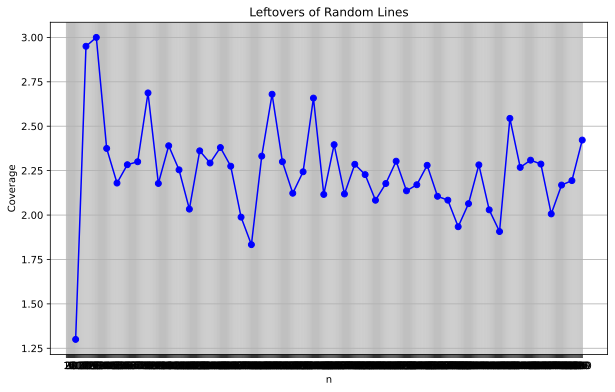

In [55]:
plot_results(normalized_raw2, title="Leftovers of Random Lines", zero_index=False)